In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from e3nn import o3
import pyvista as pv

import warnings
warnings.filterwarnings("ignore")

# Paper reading

Guaranteeing equivariance

- KineticNet: Keep track of which irreducible representation each feature belongs to; only allow operations that are equivariant
- M-OFDFT: Equivariantly choose local frames; features expressed in these frames are invariant to rotations

# Representation theory

a) Give the definition of a representation. What are irreducible representations?

A representation of a group $G$ on a vector space $V$ is a **group homomorphism** from $G$ to the group of invertible linear transformations $\mathrm{GL}(V)$, i.e. a map $\rho: G \to \mathrm{GL}(V)$ such that 
$$\rho(g_1g_2) = \rho(g_1)\rho(g_2) \qquad \forall g_1, g_2 \in G.$$

A representation is **reducible** if there exists a non-trivial subspace $W \subset V$ that is invariant under all transformations in the representation, i.e. 
$$\rho(g)W \subset W \qquad \forall g \in G.$$
If the only invariant subspaces are the trivial ones($\emptyset$ and $V$), the representation is **irreducible**.

b) A matrix $A$ transforms as $RAR^{−1}$ under a rotation $R$. Decompose $A$ into irreducible representations
of the rotation group.

A matrix is a $1 \otimes 1$ tensor, where we the integers in the tensor product notation denote the $l$. Thus, we immediately see that we can decompose the matrix as
$$1 \otimes 1 = 0 \oplus 1 \oplus 2.$$
Writing out the decomposition explicitly, we have
$$A = \frac13 \mathrm{Tr}(A)I + \frac12 (A - A^T) + \frac12(A + A^T - \frac23 \mathrm{Tr}(A)I),$$
where the first term is a scalar ($l = 0$), the second term is an antisymmetric matrix ($l = 1$), and the third term is a symmetric traceless matrix ($l = 2$):

The scalar is given by the trace which is invariant under rotations.
To see the (pseudo-)vector part, note that one can write the antisymmetric part as $$(A - A^T)_{ij} = \epsilon_{ijk}v_{k},$$ where we use the Einstein sum convention $\epsilon_{ijk}$ is the Levi-Civita symbol. It transforms as vector, $$\left. R(A - A^T)R^T \right|_{nm} = R_{ni} \cdot \epsilon_{ijk}v_k \cdot R_{mj} =  \epsilon_{nlm} \det R\, R_{lk} v_k.$$

Due to the decomposition above, we now that the last term transforms as an $l = 2$ tensor.

c) Why does it make sense to look at irreducible representations?

The idea of equivariant machine learning is to keep track of the transformation properties during computations and add learnable parameters where we can without breaking the equivariance property. If we only considered matrix operations like multiplication and addition, we would miss out on the possibility of adding learnable parameters in many situations. By decomposing the tensors into irreducible representations, we can add learnable parameters to each irreducible representation separately, which should make the model more expressive. 

# Tensor product

a) Write down the tensor product of an $l_1$ -tensor and an $l_2$-tensor in components. Which $l$-values are allowed in the result?

The tensor product is given by
$$ (x \otimes y)^l_m = \sum_{m_1=-l_1}^{l_1} \sum_{m_2=-l_2}^{l_2} C^{lm}_{l_1m_1, l_2m_2} x^{l_1}_{m_1} y^{l_2}_{m_2},$$
where $C^{lm}_{l_1m_1, l_2m_2}$ are the Clebsch-Gordan coefficients. The allowed $l$-values are $|l_1 - l_2| \leq l \leq l_1 + l_2$.

b) Visualization and counting of weights

FullTensorProduct(5x0e+10x1o x 1x0e+1x1o+1x2e -> 15x0e+25x1o+10x1e+10x2o+15x2e+10x3o | 85 paths | 0 weights)


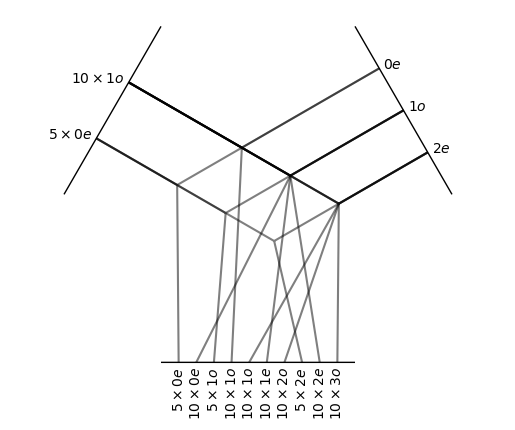

In [2]:
irreps_in1 = o3.Irreps("5x0e + 10x1o")
irreps_in2 = o3.Irreps("0e + 1o + 2e")
tp = o3.FullTensorProduct(irreps_in1=irreps_in1, irreps_in2=irreps_in2)
print(tp)
tp.visualize()
plt.show()

FullyConnectedTensorProduct(5x0e+10x1o x 1x0e+1x1o+1x2e -> 20x0e+10x1o | 550 paths | 550 weights)


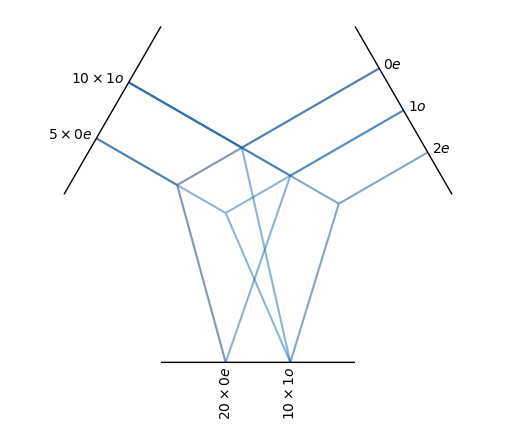

In [3]:
tp2 = o3.FullyConnectedTensorProduct(irreps_in1=irreps_in1, irreps_in2=irreps_in2, irreps_out=o3.Irreps("20x0y + 10x1y"))
print(tp2)
tp2.visualize()
plt.show()

There are five ways to obtain the 20 scalars and 10 vectors in the output:
- $5 \times 0e, 1 \times 0e \to 20 \times 0e$: 100 paths
- $10 \times 1o, 1 \times 1o \to 20 \times 0e$: 200 paths
- $5 \times 0e, 1 \times 1o \to 10 \times 0o$: 50 paths
- $10 \times 1o, 1 \times 0e \to 10 \times 1e$: 100 paths
- $10 \times 1o, 1 \times 2e \to 10 \times 1e$: 100 paths

Together, there are 550 paths.

c) Compute spherical harmonics up to order five and check the equivariance. You can generate a
random rotation matrix and use the Wigner D-matrix with the method D from matrix.

The spherical harmonics transform as

$$Y_{lm}(R x) = \sum_{m'} D^l_{m'm}(R) Y_{lm'}(x).$$

In [4]:
rot = o3.rand_matrix(dtype=torch.float64)  # random rotation matrix
x = torch.randn(100, 3, dtype=torch.float64)
x_rot = x @ rot.T

irreps = o3.Irreps("0y+1y+2y+3y+4y+5y")
y = o3.spherical_harmonics(irreps, x, normalize=True)
y_rot = o3.spherical_harmonics(irreps, x_rot, normalize=True)

D = irreps.D_from_matrix(rot)
y_rot_check = y @ D.T

torch.abs(y_rot - y_rot_check).max()

tensor(8.3700e-07, dtype=torch.float64)

d) Wigner D-matrix

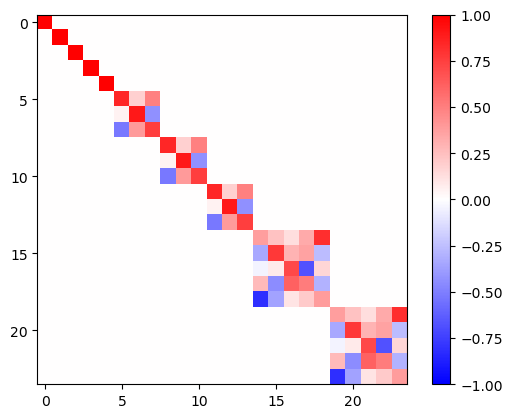

In [5]:
rot = o3.rand_matrix()  # random rotation matrix

irreps = o3.Irreps("5x0e+3x1o+2x2e")
D = irreps.D_from_matrix(rot)

plt.imshow(D, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

The matrix is block-diagonal, where each block corresponds to an irreducible representation. 

e) Equivariant kernels

In [6]:
irreps = o3.Irreps("5y")

def radial_function(r):
	return torch.sin(r) / r

n_grid = 200
x = torch.linspace(-10, 10, n_grid, dtype=torch.float64)
y = torch.linspace(-10, 10, n_grid, dtype=torch.float64)
z = torch.linspace(-10, 10, n_grid, dtype=torch.float64)
x, y, z = torch.meshgrid(x, y, z)

coords = torch.stack([x, y, z], dim=-1)
sph_harm = o3.spherical_harmonics(irreps, coords.reshape(-1, 3), True).reshape(n_grid, n_grid, n_grid, -1)
values = sph_harm * radial_function(coords.norm(dim=-1))[..., None]

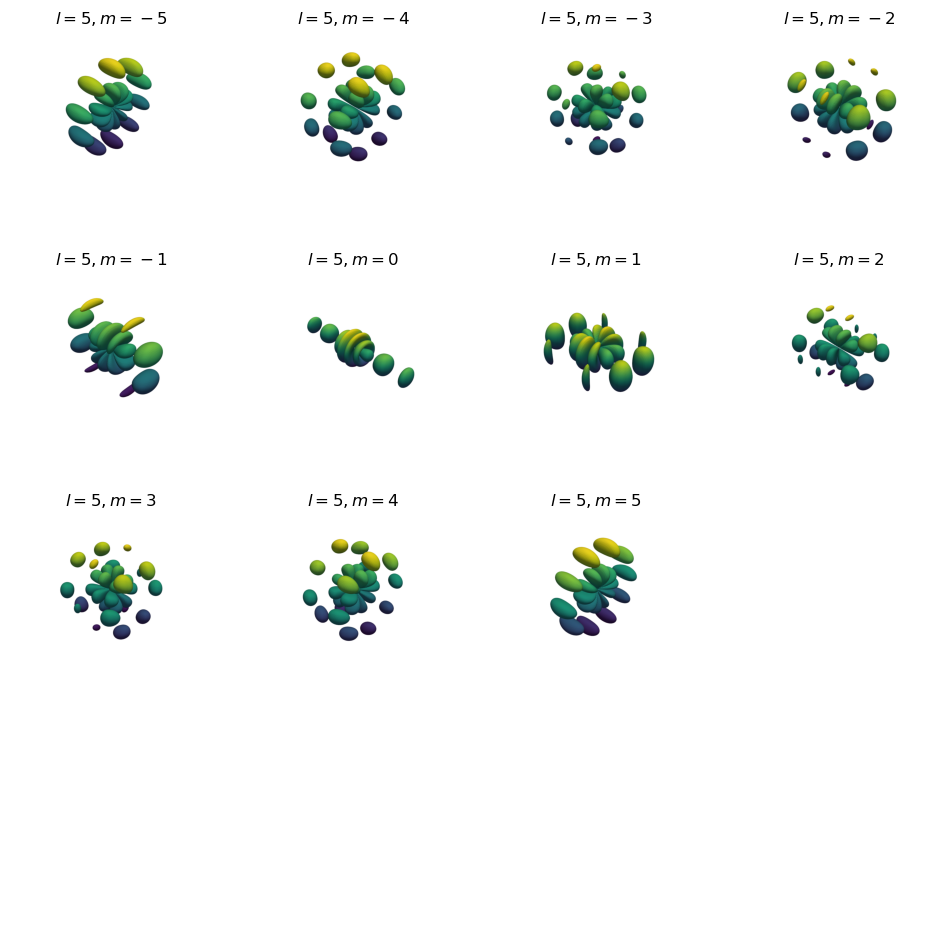

In [7]:
grid = pv.StructuredGrid(x.numpy(), y.numpy(), z.numpy())   
pv.set_plot_theme('document')

size = np.ceil(np.sqrt(irreps.dim)).astype(int)
fig, axes = plt.subplots(size, size, figsize=(3*size, 3*size))

if size == 1:
    axes = np.array([[axes]])

for i, ax in enumerate(axes.flat):
    try:
        grid["vol"] = values[:,:,:,i].flatten()
        contours = grid.contour([-0.1, 0.1])
        
        p = pv.Plotter()
        p.add_mesh(contours, scalars=contours.points[:, 2], show_scalar_bar=False)
        img = p.screenshot()
        ax.imshow(img)
        ax.set_axis_off()
        ax.set_title(f"$l={irreps.ls[0]}, m={i - irreps.ls[0]}$")
    except IndexError:
        ax.set_axis_off()
    
plt.show()